In [22]:
# 使わないやつもimportしてると思う
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.font_manager as fm
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import scipy
import seaborn as sns

from sklearn.preprocessing import LabelEncoder


In [23]:
# CPU Multi
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

import jax
print(jax.default_backend())
print(jax.devices("cpu"))

cpu
[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7)]


In [24]:
import pymc as pm
import arviz as az
print('version.', pm.__version__)

version. 5.8.0


In [25]:
train_df = pd.read_csv('4-3-1-fish-num-4.csv')
# w_encoder = LabelEncoder()
# train_df['weather'] = w_encoder.fit_transform(train_df['weather'])
h_encoder = LabelEncoder()
train_df['human'] = h_encoder.fit_transform(train_df['human'])
train_df

,fish_num,temperature,human
0,2,12.7,0
1,6,13.7,1
2,9,15.7,2
3,5,19.1,3
4,11,12.0,4
...,...,...,...
89,0,11.4,8
90,15,10.3,9
91,10,15.1,9
92,11,16.2,9


In [26]:
train_df.shape

(94, 3)

In [21]:
train_df.shape[0]

94

In [5]:
train_df.columns[1:]

Index(['temperature', 'human'], dtype='object')

In [62]:
X_cols = ['temperature']

human_idx = train_df['human'].values.astype(int)

# モデルの定義
with pm.Model() as model_poiss:
    # coords(次元やインデックスを定義)
    model_poiss.add_coord('data', values=range(train_df.shape[0]), mutable=True)
    model_poiss.add_coord('var', values=X_cols, mutable=True)

    # 説明変数
    x = pm.MutableData('x', train_df[X_cols].to_numpy(dtype='float32'), dims=('data', 'var'))
    y = pm.MutableData("y", train_df['fish_num'].to_numpy(dtype='float32'), dims=('data', ))

    # 推論パラメータの事前分布
    coef_ = pm.Normal('coef', mu=0.0, sigma=100, dims="var")  # 各係数の事前分布は正規分布
    intercept_ = pm.Normal('intercept', mu=0.0, sigma=100)  # 切片の事前分布は正規分布

    # 釣り人ごとのランダム切片
    sigma_r = pm.HalfNormal('sigma-r', sigma=10)  # 属性ごとのランダム切片の標準偏差
    r_ = pm.Normal('r-intercept', mu=0, sigma=sigma_r, shape=len(train_df['human'].unique()))

    # 釣り人ごとのランダム係数
    sigma_t = pm.HalfNormal('sigma-t', sigma=1)  # 属性ごとのランダム係数の標準偏差
    t_ = pm.Normal('r-coef', mu=0, sigma=sigma_t, shape=len(train_df['human'].unique()))
    # t_ = pm.Normal('r-coef', mu=0, sigma=sigma_t, shape=(len(train_df['human'].unique()),1))　# t_のshapeを変更してもエラー

    # coef_sum = pm.Deterministic('coef-sum', coef_ + t_[human_idx], dims=('data', ))


    # linear model
    # mu = pm.Deterministic("mu", coef_.dot(x.T) + intercept_ + r_[human_idx], dims=('data', ))

    mu = pm.Deterministic("mu", coef_.dot(x.T) + 
                        # pm.math.dot(t_[train_df['human']], x)[:,0] + # この表記だと、pm.sample()でエラー
                        # (t_[train_df['human']]).dot(x.T) + # この表記でも、pm.sample()でエラー
                        (t_[train_df['human']])*(x.T)[0] + # *で掛け算したらうまくいった
                        intercept_ + 
                        r_[train_df['human']], dims=('data', ))
    # link function
    result = pm.Poisson("obs", pm.math.exp(mu), observed=y, dims=('data', ))
    # # likelihood
    # result = pm.Bernoulli("obs", p=link, observed=y, dims=('data', ))

# 定義した各パラメータの情報
display(model_poiss.model)

       coef ~ Normal(0, 100)
  intercept ~ Normal(0, 100)
    sigma-r ~ HalfNormal(0, 10)
r-intercept ~ Normal(0, sigma-r)
    sigma-t ~ HalfNormal(0, 10)
     r-coef ~ Normal(0, sigma-t)
         mu ~ Deterministic(f(r-intercept, intercept, coef, r-coef))
        obs ~ Poisson(f(r-intercept, intercept, coef, r-coef))

In [12]:
(coef_.dot(x.T) + (t_[train_df['human']]).dot(x.T) + intercept_ + r_[train_df['human']]).shape.eval()

array([94])

In [56]:
(t_[train_df['human']] * x.T).shape.eval()

array([ 1, 94])

In [14]:
(t_[train_df['human']]).dot(x.T).shape.eval()

array([94])

In [15]:
coef_.dot(x.T).shape.eval()

array([94])

In [30]:
x.T.shape.eval()

array([ 1, 94])

In [31]:
t_[train_df['human']].shape.eval()

array([94])

In [18]:
t_[train_df['human']].shape.eval()

array([94])

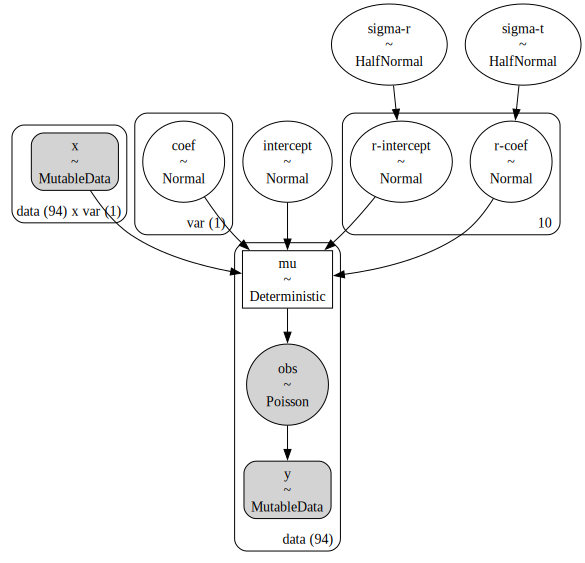

In [63]:
# 構造
modeldag = pm.model_to_graphviz(model_poiss)
display(modeldag)


In [64]:
%%time
# MCMC実行
# バックエンドでNumPyroで実行
with model_poiss:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, nuts_sampler="numpyro", 
                        random_seed=1, return_inferencedata=True,)
# >> Wall time: 45.5 s
# データの保存 to_netcdfの利用
# trace.to_netcdf('model_random1.nc')
# データの読み込み from_netcdfの利用
#trace = az.from_netcdf('model_random1.nc')


Compiling...
Compilation time =  0:00:00.728757
Sampling...


Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]


Running chain 2: 100%|██████████| 4000/4000 [00:02<00:00, 1677.67it/s]


Sampling time =  0:00:02.476966
Transforming variables...
Transformation time =  0:00:00.095787
CPU times: user 4.83 s, sys: 228 ms, total: 5.06 s
Wall time: 5.61 s


In [65]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

Max rhat: 1.0023437534978599


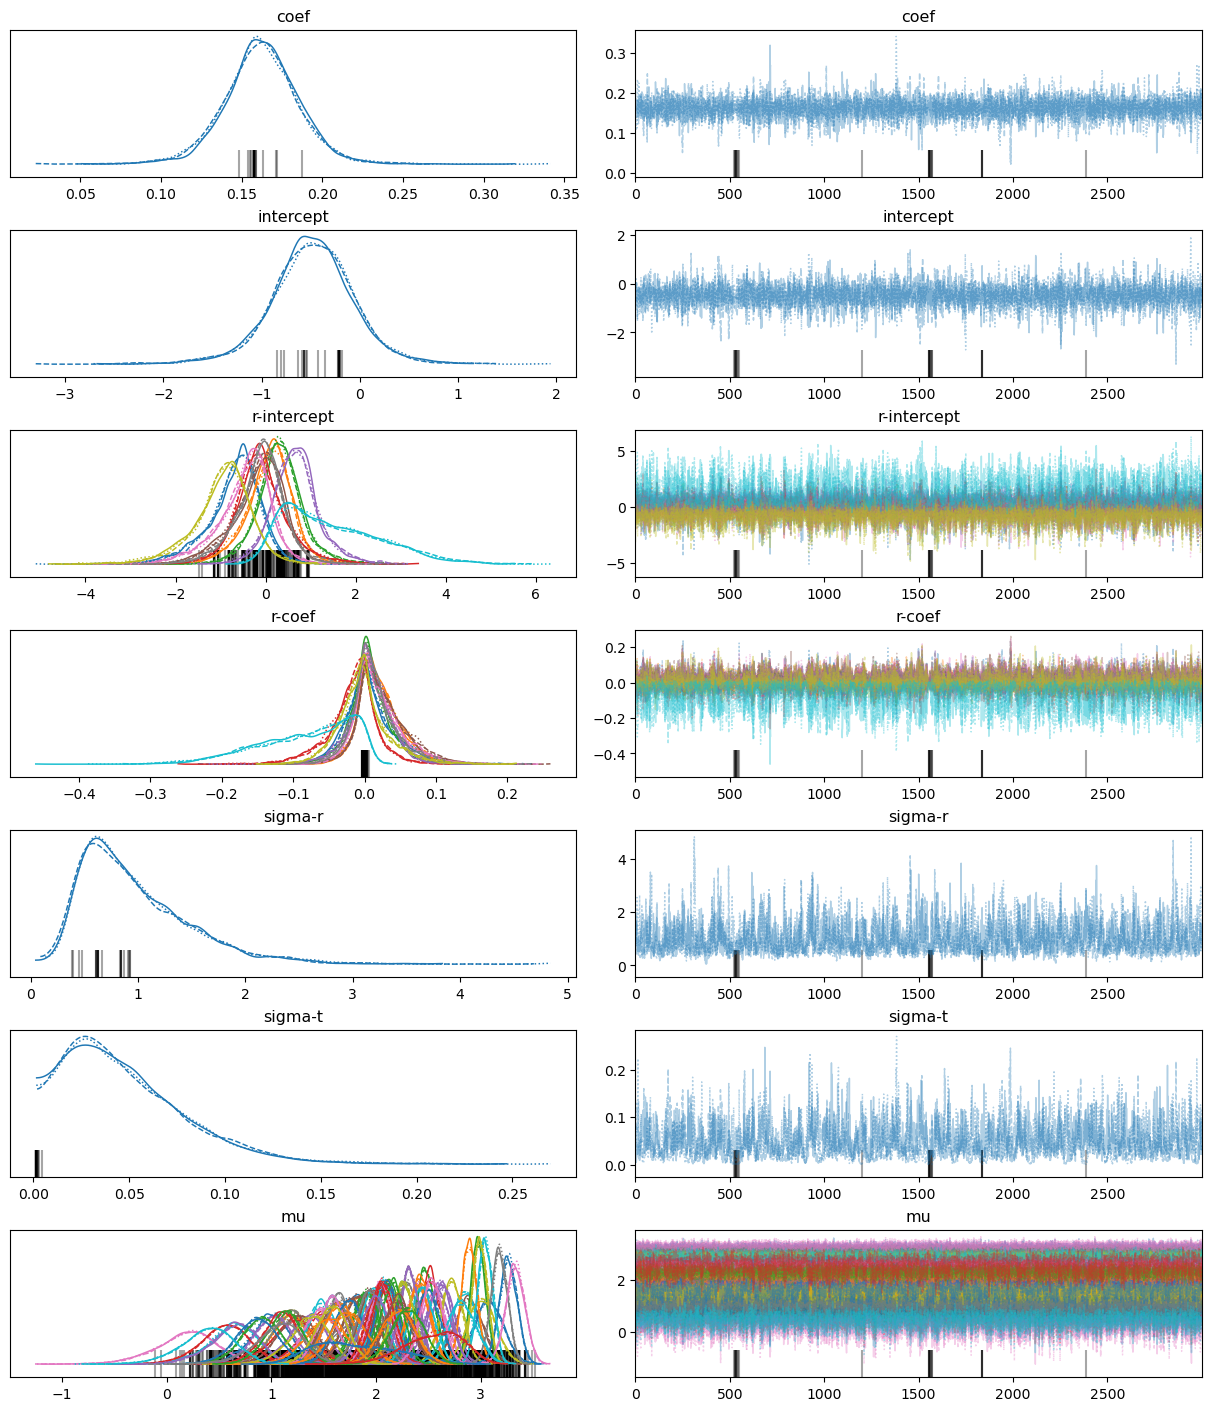

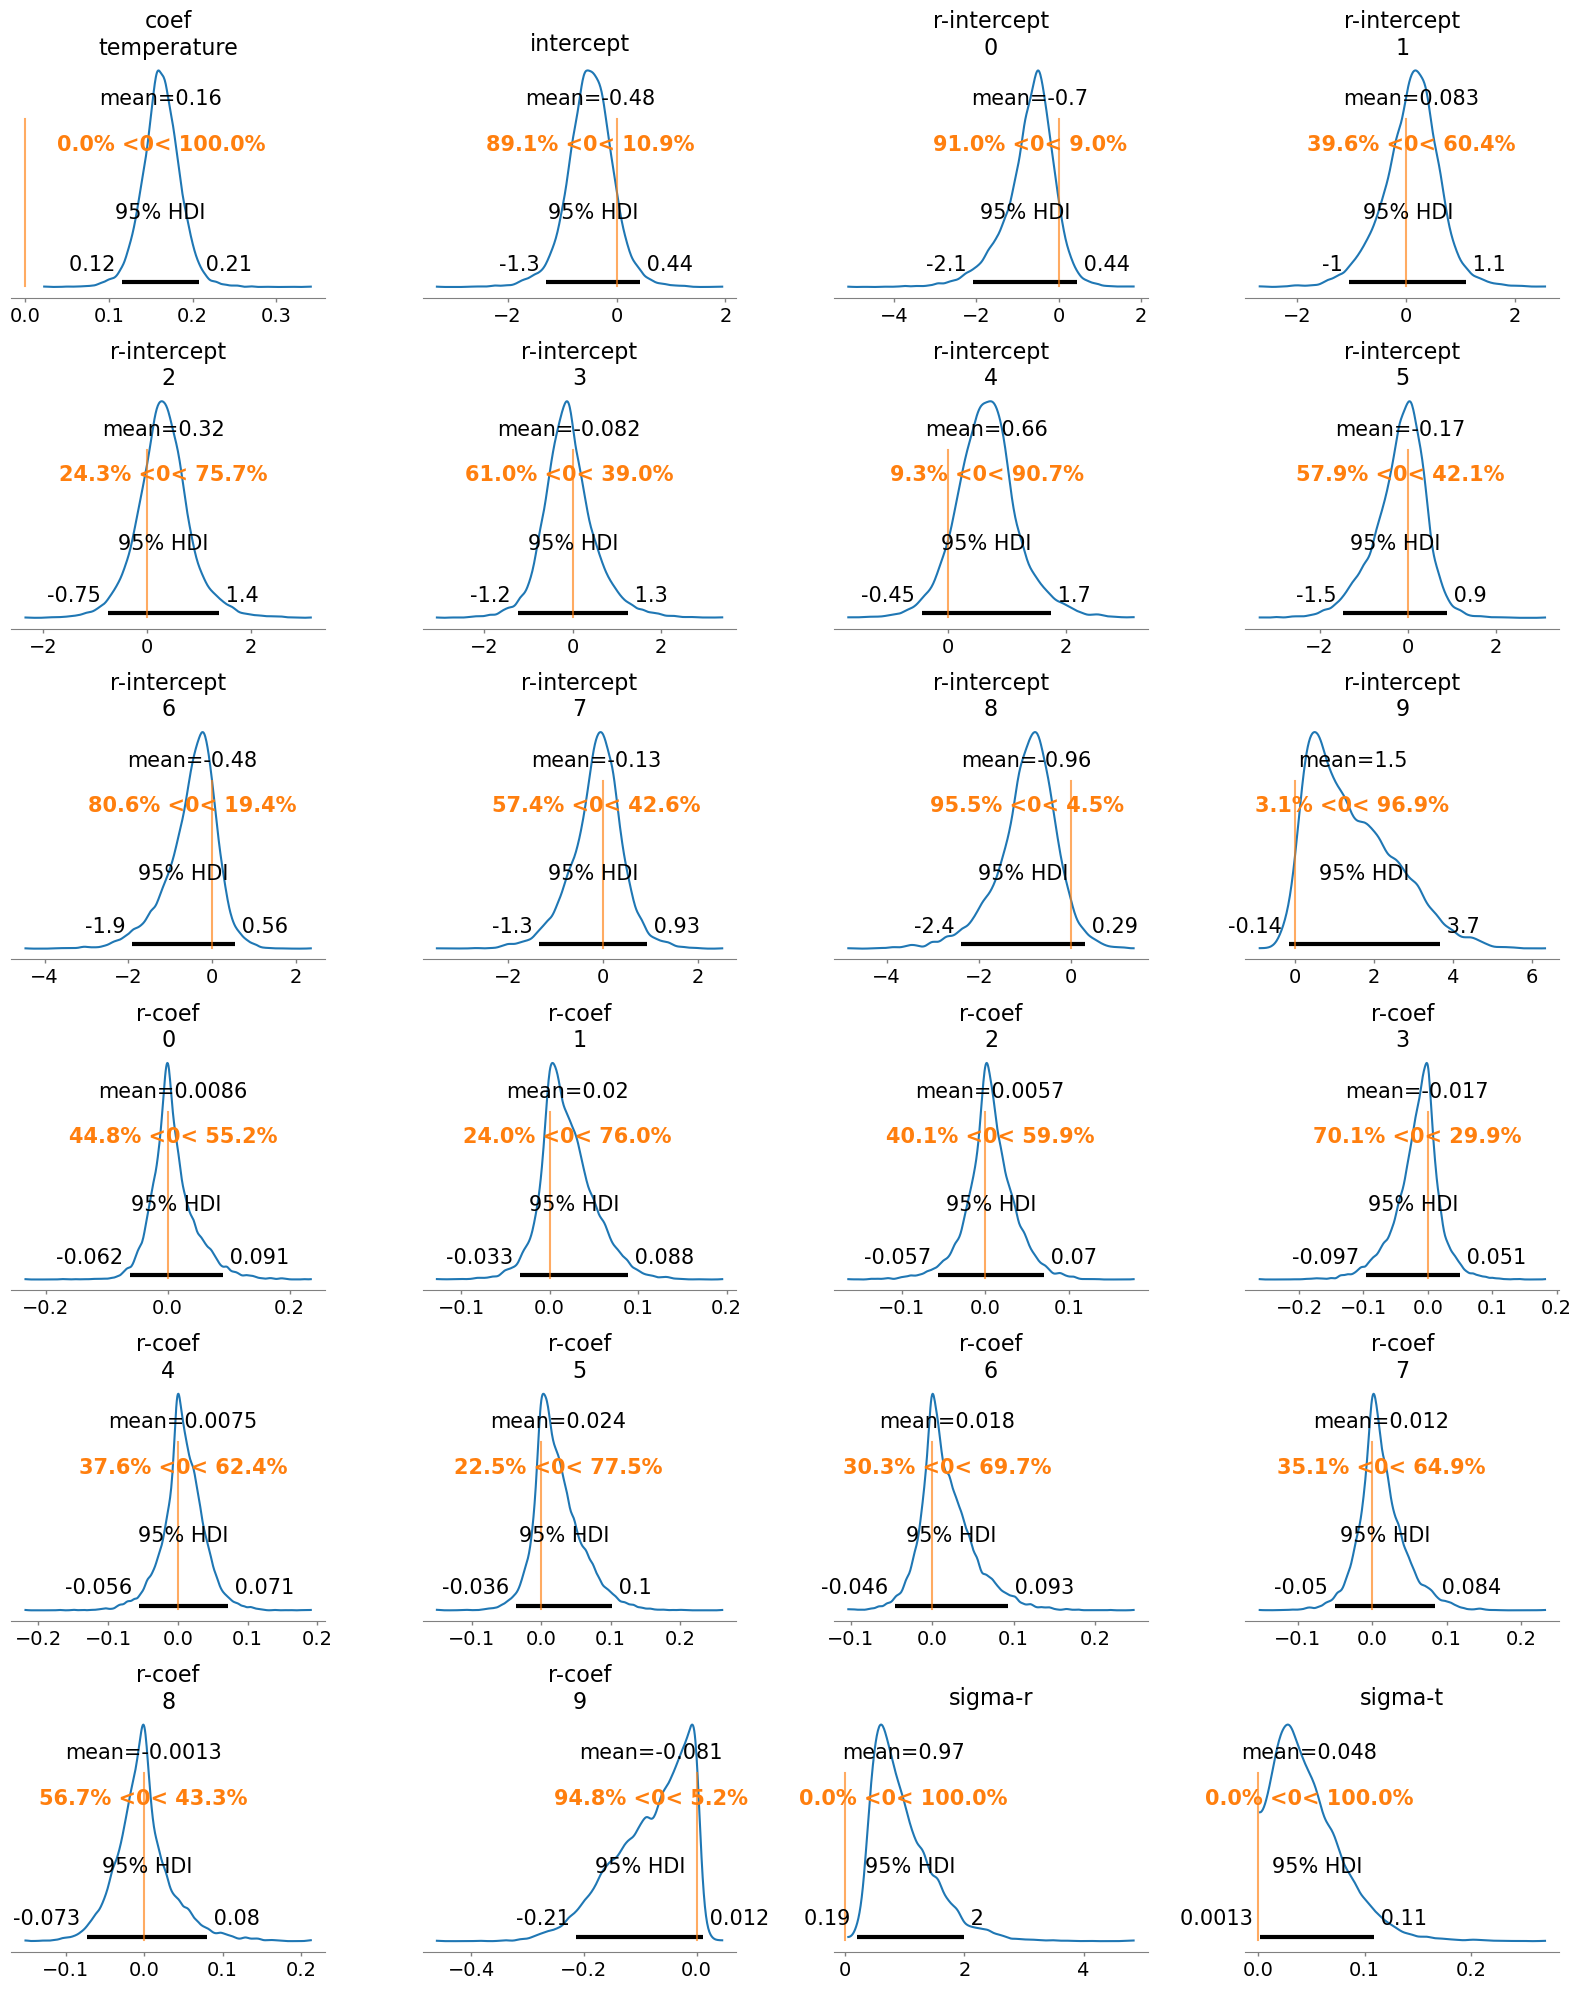

In [70]:
# MCMCの収束を評価
rhat_vals = az.rhat(trace).values()
# 最大のRhatを確認
result = np.max([np.max(i.values) for i in rhat_vals if i.name in ["coef", "intercept", "r-intercept", "r-coef", "sigma-r", "sigma-t", 'mu']])
print('Max rhat:', result)
# 1.1以上のRhatを確認
for i in rhat_vals:
    if np.max(i.values)>=1.1:
        print(i.name, np.max(i.values), np.mean(i.values), i.values.shape, sep='  ====>  ')


# トレースプロットとか
# plot_trace
az.plot_trace(trace, backend_kwargs={"constrained_layout":True}, var_names=["coef", "intercept", "r-intercept", "r-coef", "sigma-r", "sigma-t", 'mu'])
plt.show()

# # forest plotでRハットと一緒に可視化
# az.plot_forest(trace, combined=True, hdi_prob=0.95, r_hat=True, var_names=["coef", "intercept", "random", 'mu'])
# plt.tight_layout()
# plt.show()

# 事後分布の確認
az.plot_posterior(trace, hdi_prob=0.95, var_names=["coef", "intercept", "r-intercept", "r-coef", "sigma-r", "sigma-t"], ref_val=0, figsize=(16,20))
plt.tight_layout()
plt.show()

# # Energy Plot
# az.plot_energy(trace)
# plt.show()


### 回帰曲線の描画